In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import csv
from time import time
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

In [239]:
IMAGES_PATH = Path("../images/")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [240]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')

In [241]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## load data

In [242]:
source = Path("../data/data.h5")

In [243]:
tick = 'msft'
strat = 'dummy_clf'

data = pd.read_hdf(source, 'models/results/{}'.format(tick))
data.index.name = 'datetime'
data.head()

open       high        low      close    volume      SMA_5     SMA_21     SMA_63  return_1d  return_5d  ...       ATR  target_1d   log_clf   svm_clf   rnd_clf   mlp_clf   vot_clf   ada_clf   grb_clf  dummy_clf
datetime                                                                                                                 ...                                                                                                      
2016-04-05  55.189999  55.299999  54.459999  49.143639  19272300  49.691283  48.471956  47.154361  -0.015820  -0.002745  ... -0.651044   0.010211  0.010211  0.010211 -0.010211  0.010211  0.010211  0.010211 -0.010211   0.010211
2016-04-06  54.360001  55.200001  54.209999  49.648037  21188700  49.703891  48.647382  47.160973   0.010211   0.001271  ... -0.639007  -0.012046 -0.012046 -0.012046  0.012046  0.012046  0.012046 -0.012046  0.012046  -0.012046
2016-04-07  54.869999  54.910000  54.230000  49.053585  19225100  49.565183  48.767909  47.172344  -0.012046  -0.014039  ... -0.670302  -0.000735 -0.000735 -0.000735  0.000735 -0.000735 -0.000735 -0.000735 -0.000735  -0.000735
2016-04-08  54.669998  55.279999  54.320000  49.017540  22167200  49.358015  48.835678  47.209830  -0.000735  -0.020912  ... -0.647798  -0.002023 -0.002023 -0.002023  0.002023 -0.002023 -0.002023 -0.002023  0.002023  -0.002023
2016-04-11  54.490002  55.150002  54.299999  48.918461  21414200  49.156252  48.932613  47.243472  -0.002023  -0.020413  ... -0.631925   0.006241  0.006241  0.006241 -0.006241 -0.006241 -0.006241  0.006241 -0.006241   0.006241

[5 rows x 38 columns]

In [244]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_21', 'SMA_63',
       'return_1d', 'return_5d', 'return_10d', 'return_21d', 'return_42d',
       'return_63d', 'HT_TRENDLINE', 'bb_high', 'bb_low', 'BB_HIGH', 'BB_LOW',
       'RSI', 'MACD', 'PLUS_DM', 'MINUS_DM', 'ADX', 'PPO', 'STOCH', 'MFI',
       'AD', 'ATR', 'target_1d', 'log_clf', 'svm_clf', 'rnd_clf', 'mlp_clf',
       'vot_clf', 'ada_clf', 'grb_clf', 'dummy_clf'],
      dtype='object')


## Backtrader setup

## commission scheme

In [245]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', .02),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

In [246]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [247]:
class SignalData(PandasData):

    cols = OHLCV + ['dummy_clf'] #modify this for different classifier

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [254]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and prediction value in the series
        self.data_prediction = self.datas[0].dummy_clf #modify this
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        #print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_prediction > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_prediction < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

### Create and configure Cerebro instance

In [255]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.broker.setcash(100000.0)
comminfo = FixedCommisionScheme()
cerebro.broker.addcommissioninfo(comminfo)

### Add input data

In [256]:
bt_data = SignalData(dataname=data)
cerebro.adddata(bt_data)

### Run strategy backtest

In [257]:
cerebro.addstrategy(MLStrategy)

0

In [258]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [259]:

results = cerebro.run()
ending_value = cerebro.broker.getvalue()
print(f'Final Portfolio Value: {ending_value:,.2f}')


Final Portfolio Value: 2,653,922.10


In [260]:
# Extract inputs for pyfolio
pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = strat
returns.head(2)

index
2016-04-05 00:00:00+00:00    0.0
2016-04-06 00:00:00+00:00    0.0
Name: dummy_clf, dtype: float64

In [261]:
# get benchmark returns
passive_rets= data['target_1d']
passive_rets.index = passive_rets.index.tz_localize('UTC') 
passive_rets = passive_rets.filter(returns.index)
passive_rets.name = 'Buy-n-Hold'
passive_rets.head(2)

datetime
2016-04-05 00:00:00+00:00    0.010211
2016-04-06 00:00:00+00:00   -0.012046
Name: Buy-n-Hold, dtype: float64

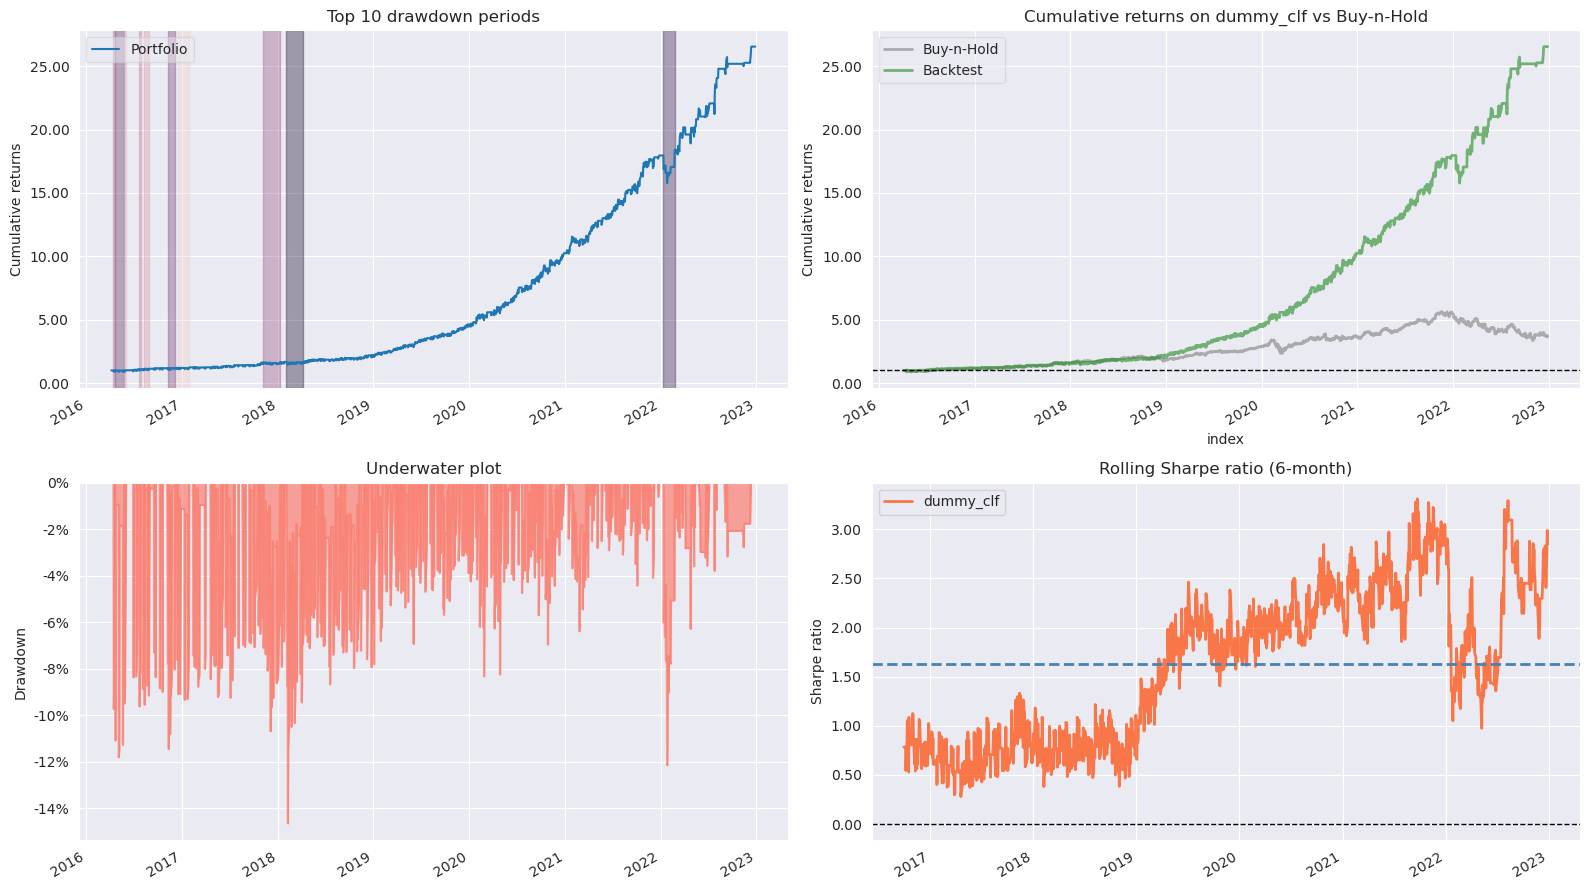

In [262]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()
pf.plot_drawdown_periods(returns=returns, ax=axes[0])
pf.plot_rolling_returns(returns=returns,
                        factor_returns=passive_rets,
                        ax=axes[1], 
                        title='Cumulative returns on {} vs {}'
                        .format(strat, passive_rets.name))
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])


plt.legend()
plt.tight_layout()
save_fig("backtest_{}_{}_passive".format(tick,strat))

In [226]:
pf.show_perf_stats(returns=returns, positions=positions, transactions=transactions)

## Save results

In [227]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

#export
export_path = Path('../data/backtrader.h5')
returns.to_hdf(export_path, 'pyfolio/{}/{}/returns'.format(tick,strat))
positions.to_hdf(export_path, 'pyfolio/{}/{}/positions'.format(tick,strat))
transactions.to_hdf(export_path, 'pyfolio/{}/{}/transactions/'.format(tick,strat))
gross_lev.to_hdf(export_path, 'pyfolio/{}/{}/gross_lev'.format(tick,strat))

##  pyfolio analysis

In [228]:
benchmark = pd.read_hdf('../data/assets.h5', 'yfinance/prices/test/vti')

In [229]:
benchmark = benchmark.loc[data.index]
benchmark

Open        High         Low       Close   Adj Close   Volume
datetime                                                                       
2016-04-05  104.309998  104.550003  103.870003  104.019997   92.009361  2572500
2016-04-06  104.089996  105.199997  103.900002  105.160004   93.017715  2572000
2016-04-07  104.500000  104.739998  103.440002  103.900002   91.903206  2134800
2016-04-08  104.570000  104.900002  103.910004  104.199997   92.168571  2337000
2016-04-11  104.650002  105.050003  103.910004  103.910004   91.912071  2276300
...                ...         ...         ...         ...         ...      ...
2022-12-22  191.610001  191.679993  187.380005  190.369995  189.607086  5153500
2022-12-23  190.000000  191.440002  189.009995  191.419998  190.652878  4214400
2022-12-27  191.389999  191.520004  189.750000  190.619995  189.856079  6037700
2022-12-28  190.649994  191.500000  188.059998  188.220001  187.465714  5711900
2022-12-29  189.490005  192.160004  189.369995  191.679993  190.911835  5425700

[1698 rows x 6 columns]

In [230]:
benchmark.index.name = 'datetime'
benchmark_rets = benchmark['Adj Close'].pct_change()
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'VTI'
benchmark_rets.head(2)

datetime
2016-04-05 00:00:00+00:00         NaN
2016-04-06 00:00:00+00:00    0.010959
Name: VTI, dtype: float64

In [231]:
benchmark['Adj Close'].pct_change().sum()

0.8587963969548106

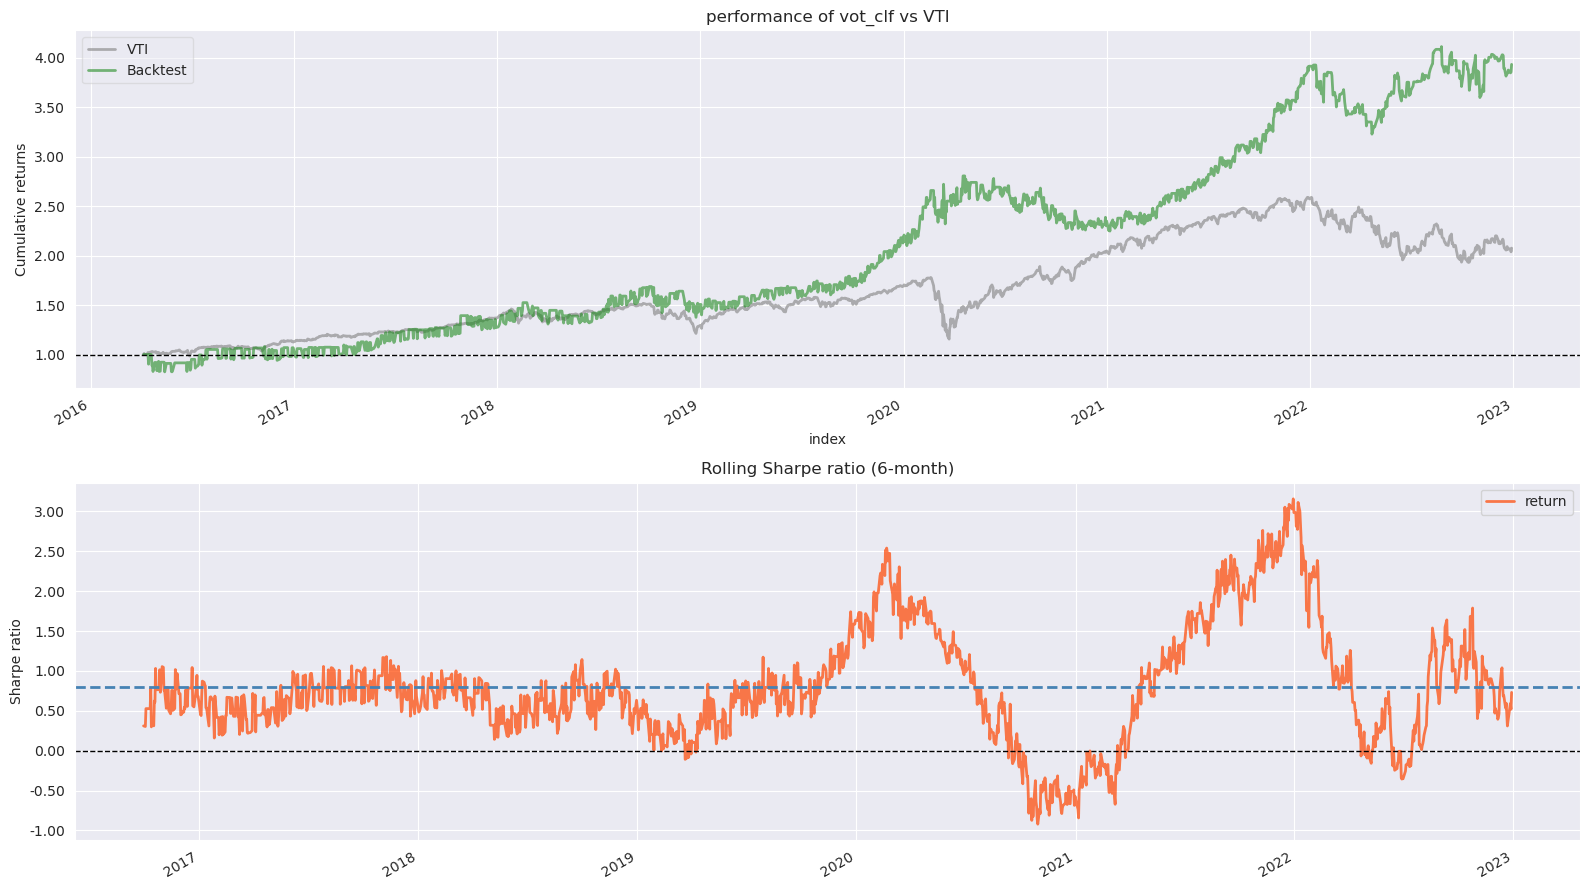

In [232]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[0], 
                        title='performance of {} vs {}'
                       .format(strat,benchmark_rets.name))
axes[1].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[1])

plt.grid(True)
plt.legend()
plt.tight_layout()
save_fig("backtest_{}_{}_{}".format(tick,strat,benchmark_rets.name))

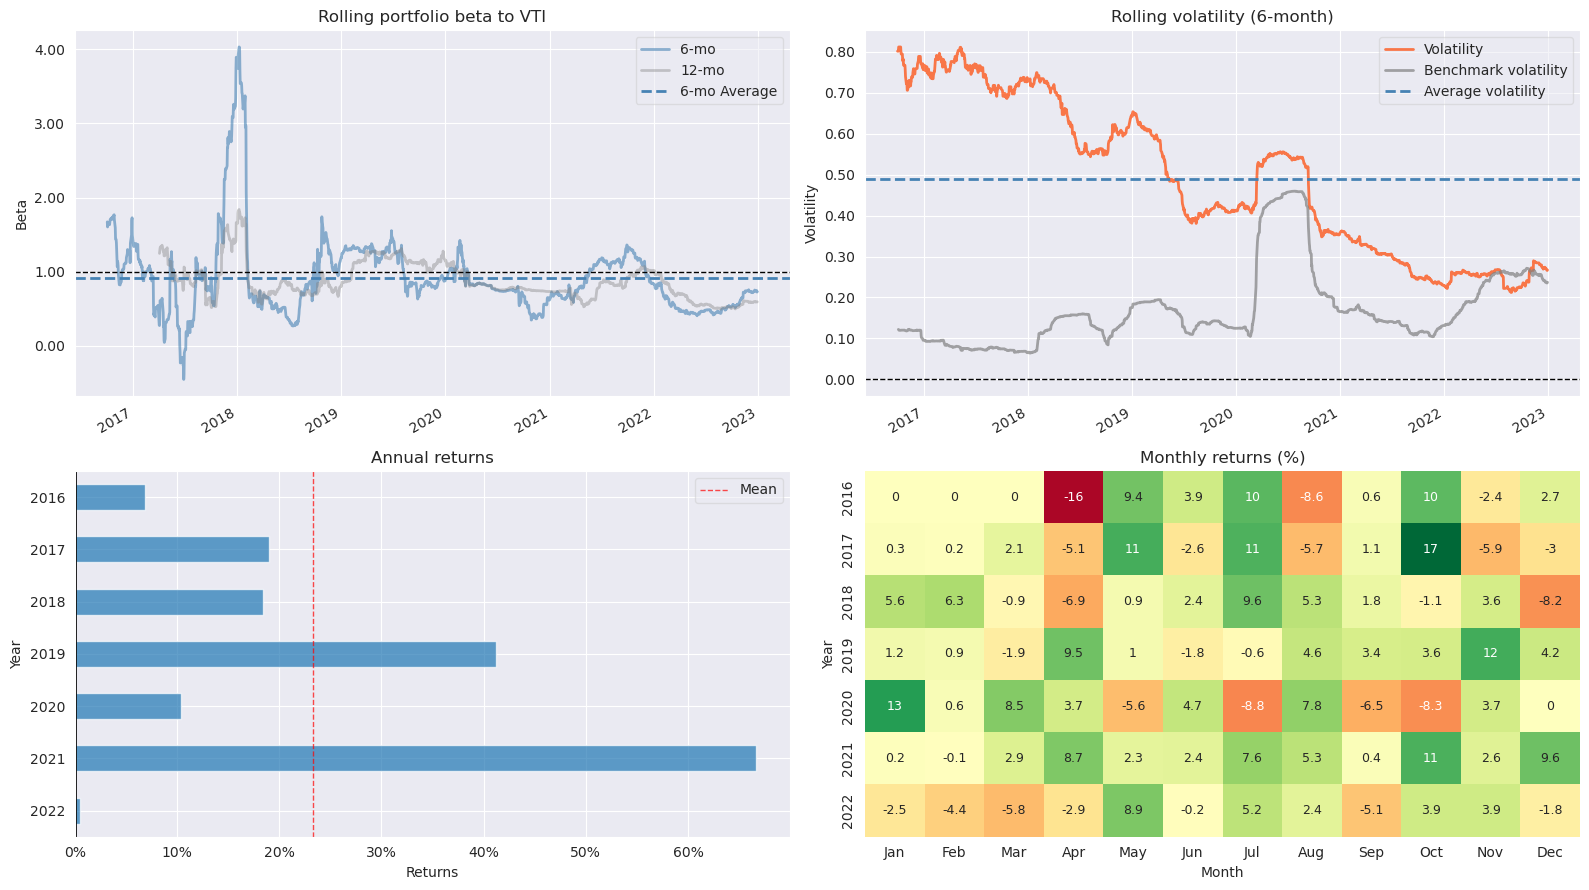

In [54]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
pf.plot_annual_returns(returns=returns, ax=axes[2])
pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)

plt.tight_layout()
save_fig("pyfolio_results _{}_{}".format(tick,strat,benchmark_rets.name))

In [161]:
from pyfolio import timeseries 
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=returns, 
                           factor_returns=benchmark_rets,
                           positions=positions, 
                           transactions=transactions, 
                           turnover_denom="AGB")
perf_stats_all

Annual return          0.225258
Cumulative returns     2.930833
Annual volatility      0.530288
Sharpe ratio           0.648293
Calmar ratio           1.133501
Stability              0.967285
Max drawdown          -0.198727
Omega ratio            1.144276
Sortino ratio          0.942923
Skew                   0.048493
Kurtosis               2.264327
Tail ratio             1.035746
Daily value at risk   -0.065446
Gross leverage         0.451581
Daily turnover         0.893281
Alpha                  0.275170
Beta                   0.790311
dtype: float64

In [157]:
%%capture Jupyter 
pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions,
                          benchmark_rets=benchmark_rets.dropna())

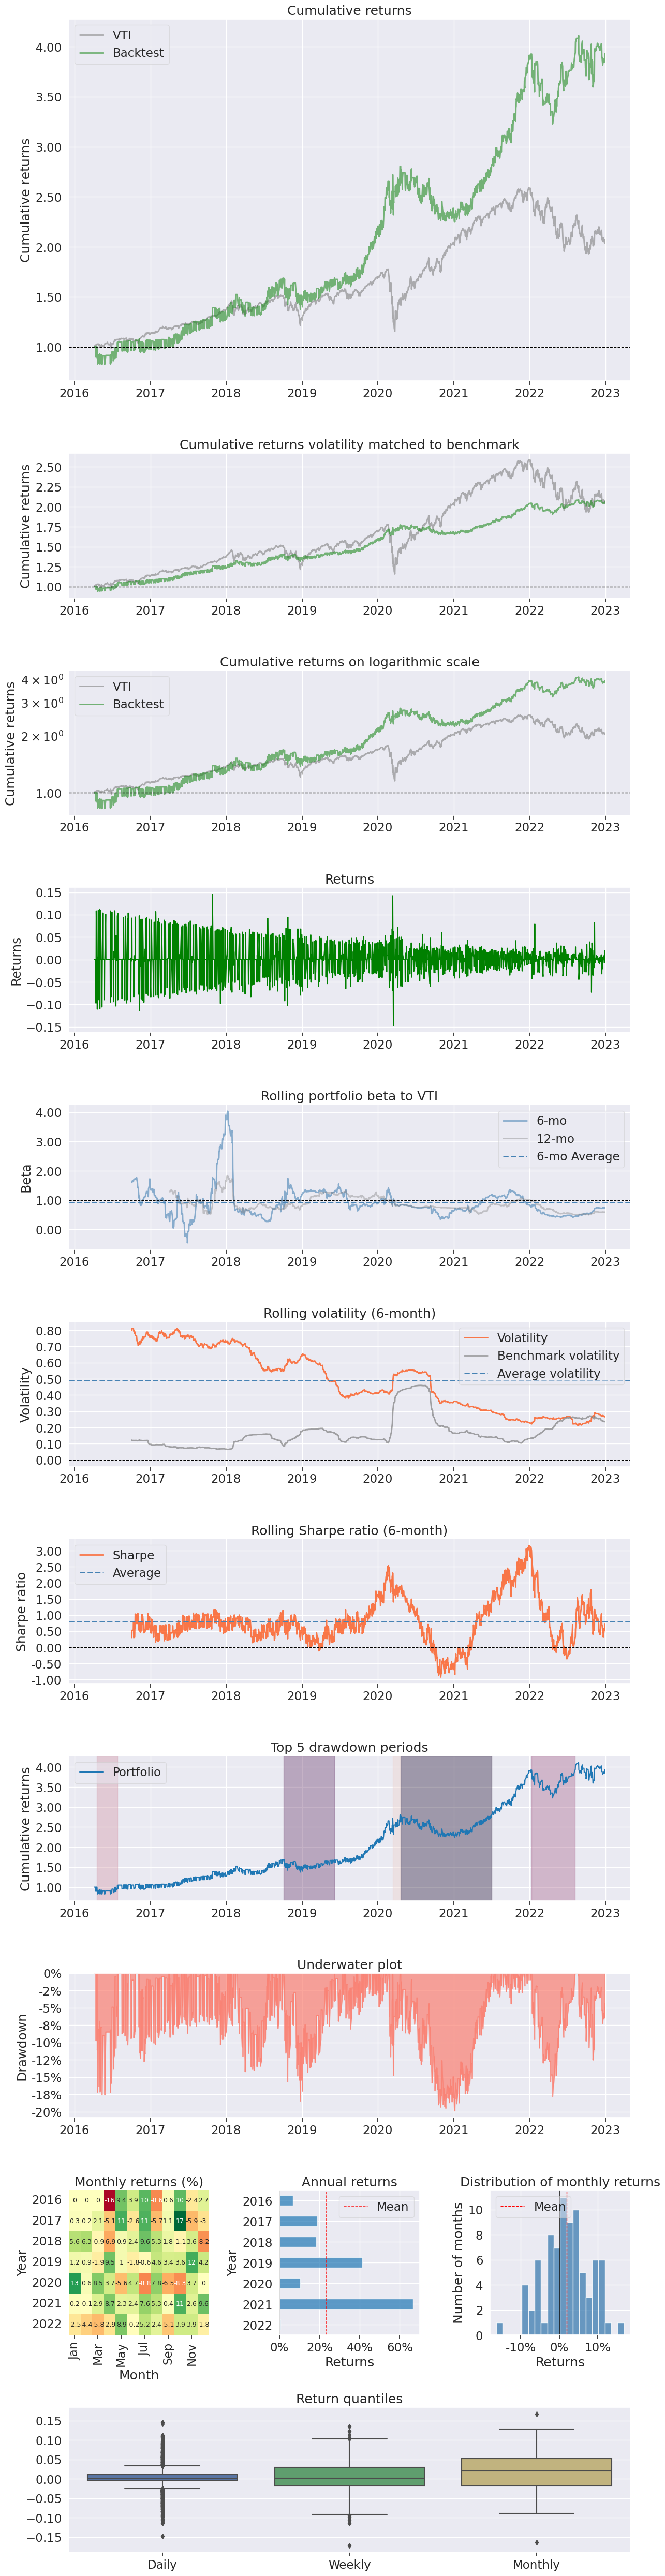

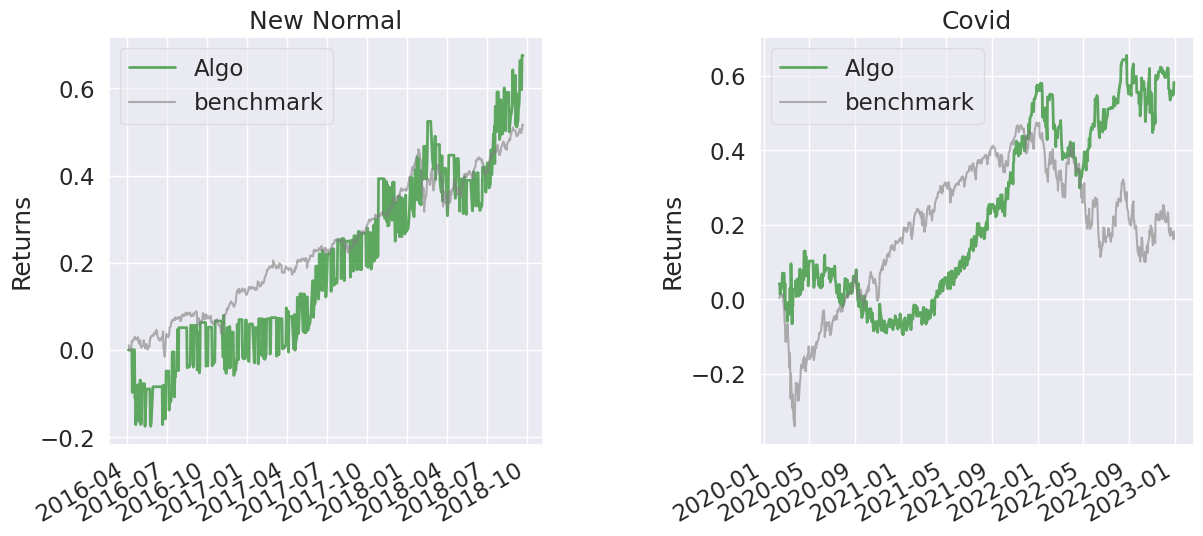

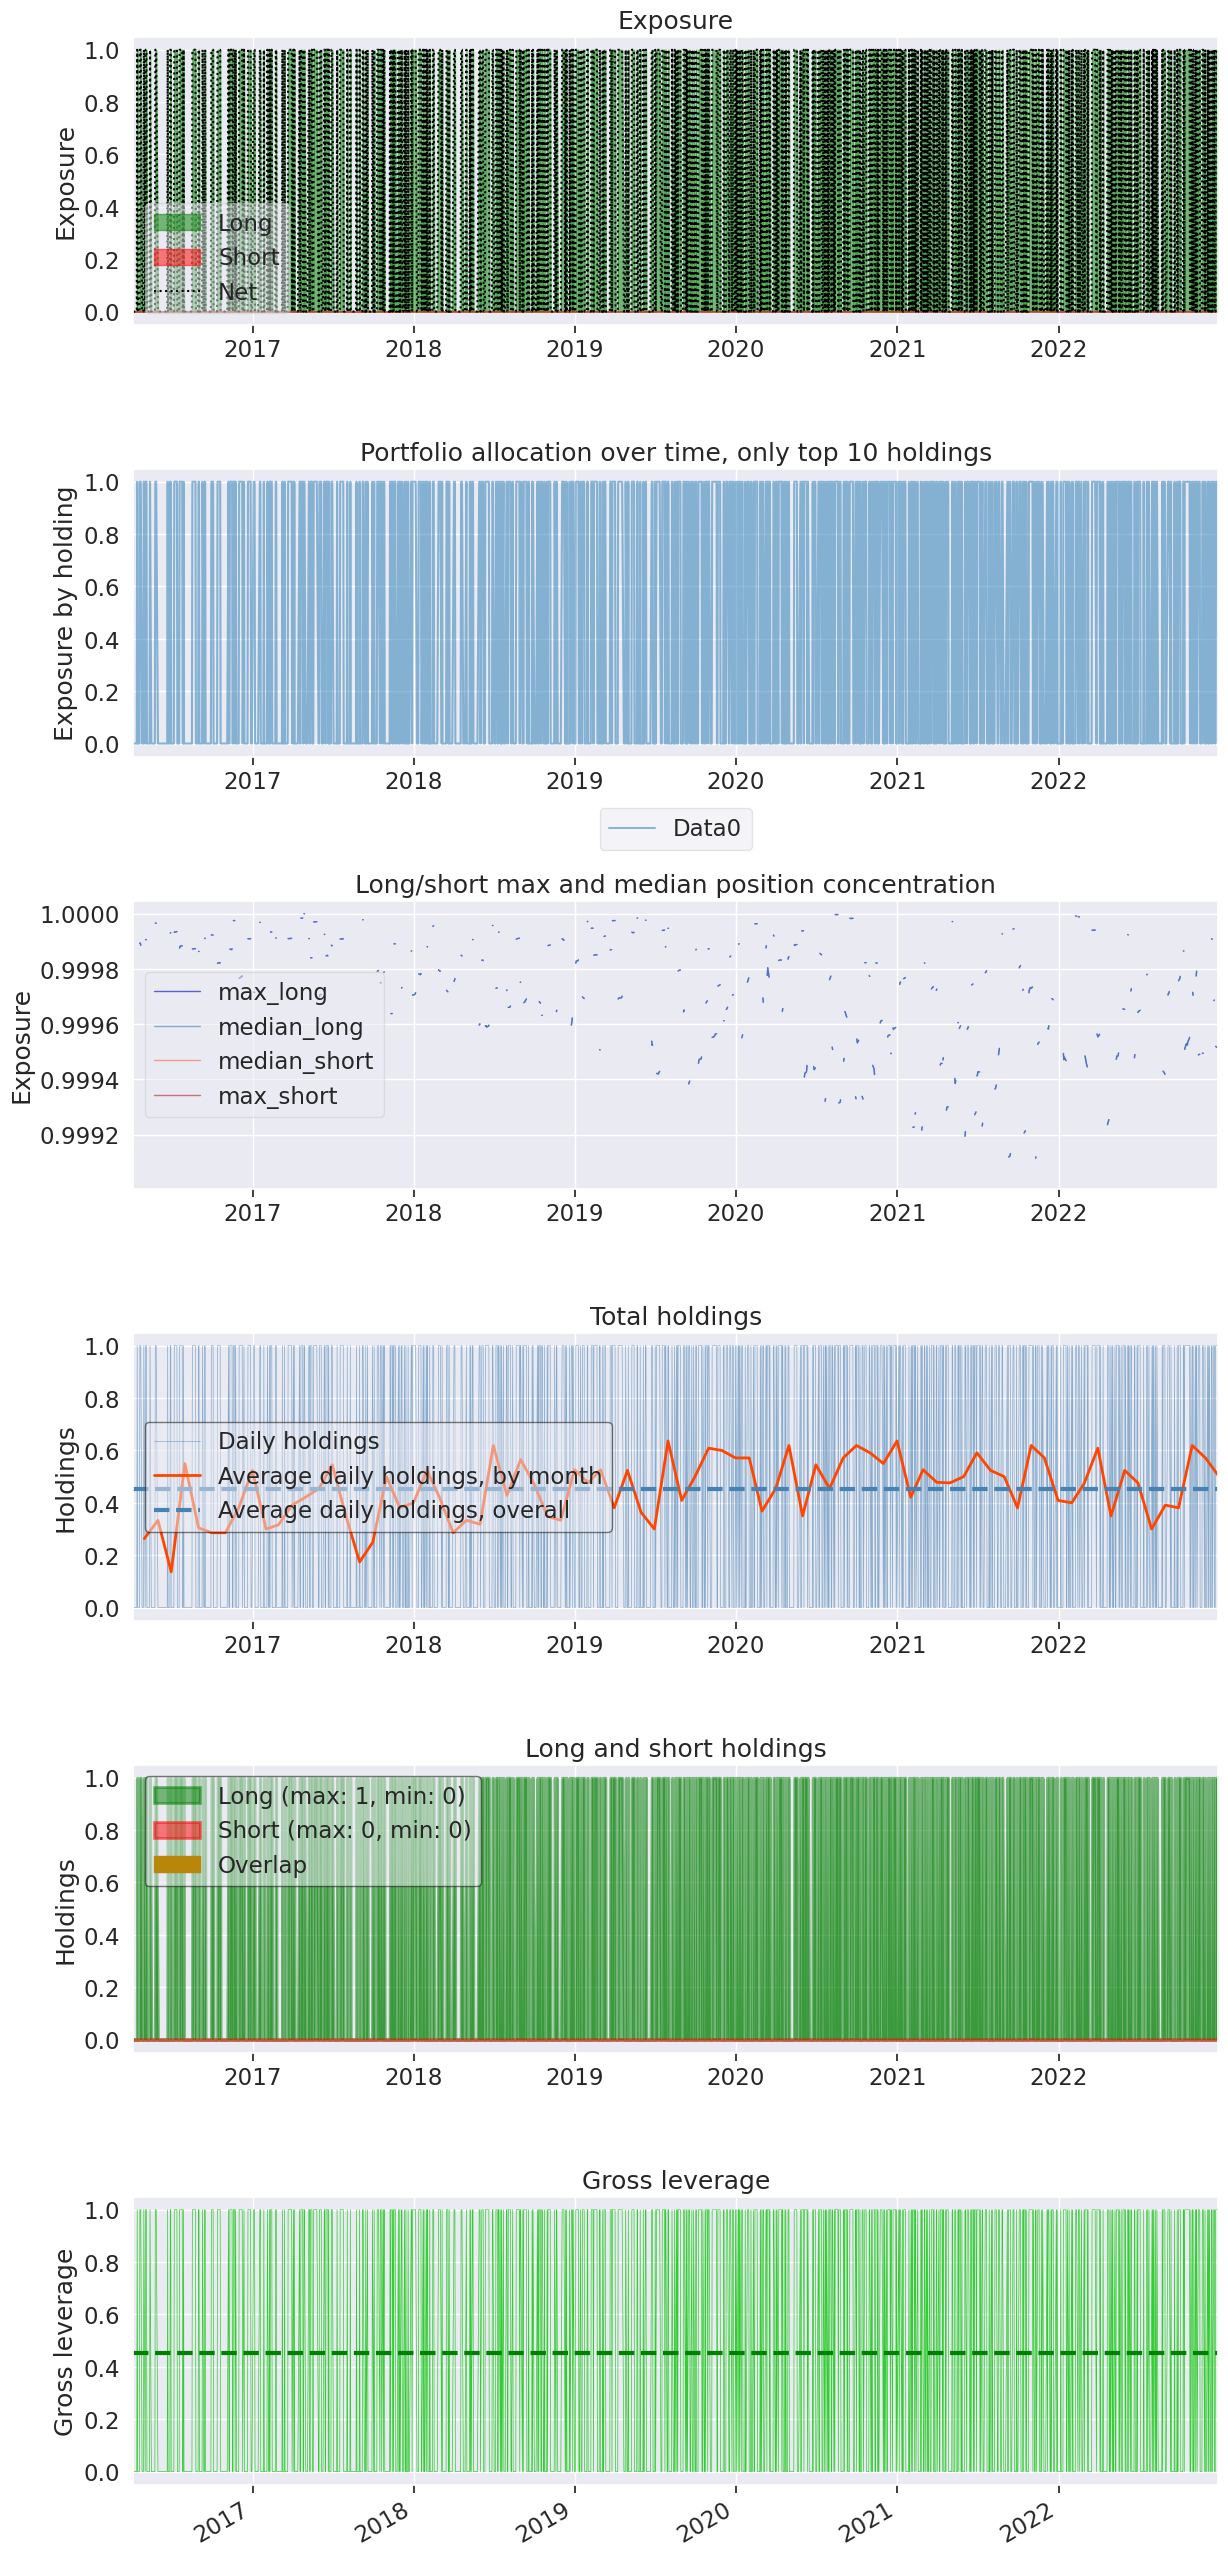

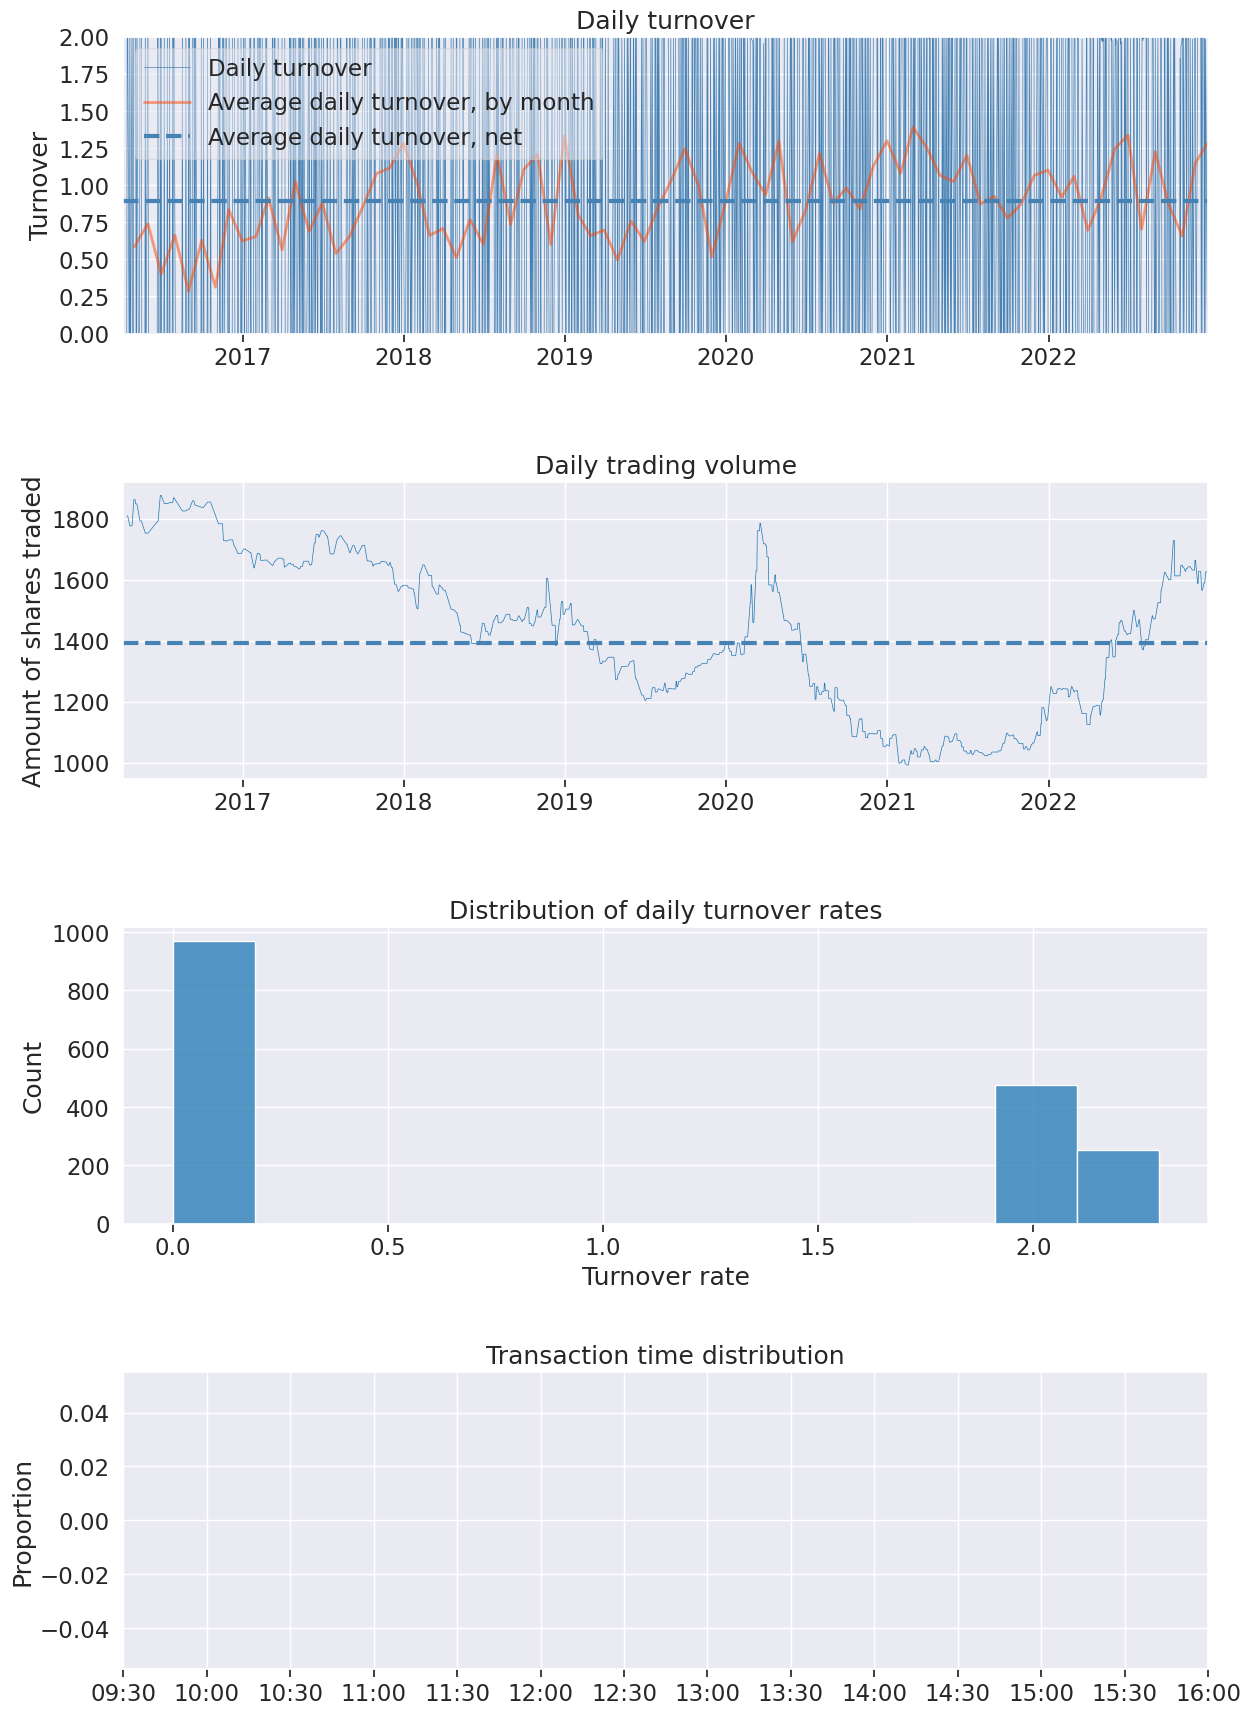

In [162]:
Jupyter.show()